In [1]:
generating_class = 'TUG'
real_dir = 'DATASET54000'
fake_dir = 'DCGAN-F64'
fake_dirx4 = 'DCGAN-F64x4'

In [2]:
from keras import layers
from keras import ops
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import os
import keras
import tensorflow as tf

import torch
import torchvision
import cv2

from realesrgan import RealESRGANer
from basicsr.archs.rrdbnet_arch import RRDBNet
from PIL import Image
import numpy as np
import requests

from skimage.metrics import structural_similarity as ssim
from torchvision import transforms
from torchmetrics.image.inception import InceptionScore
from torchmetrics.image.fid import FrechetInceptionDistance
from itertools import product


print(f"Versão do Tensorflow: {tf.__version__}")
devices = tf.config.list_physical_devices('GPU')
if devices:
    print(f"GPU disponivel: {devices}")
    print(f"Número de GPUs: {len(devices)}")
else:
    print("GPU não está disponível. Usando CPU")

print(f"PyTorch version: {torch.__version__}")
print(torchvision.__version__)
print(torch.cuda.is_available())  # Deve retornar True se a GPU estiver configurada corretamente
print(torch.cuda.get_device_name(0))  # Nome da GPU

2025-04-19 01:03:55.676983: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-19 01:03:55.698873: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/local/lib/python3.11/dist-packages/torchvision/transforms/functional_tensor.py:5: UserWarning: The torchvision.transforms.functional_tensor module is deprecated in 0.15 and will be **removed in 0.17**. Please don't rely on it. You probably just need to use APIs in torchvision.transforms.functional or in torchvision.transforms.v2.functional.
  warnings.war

Versão do Tensorflow: 2.16.1
GPU disponivel: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Número de GPUs: 1
PyTorch version: 2.0.1+cu118
0.15.2+cu118
True
NVIDIA GeForce RTX 4090


2025-04-19 01:03:57.568954: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-19 01:03:57.568971: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


Found 5400 files.


2025-04-19 01:04:04.287722: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-19 01:04:04.287757: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-19 01:04:04.287767: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-19 01:04:04.423079: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-19 01:04:04.423106: I external/local_xla/xla/stream_executor

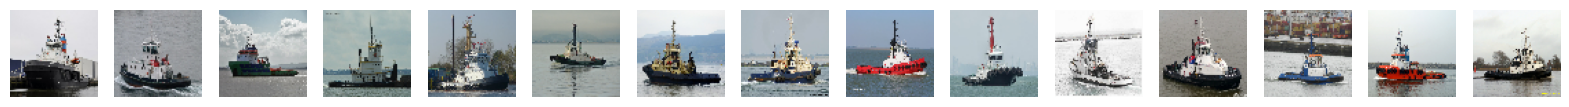

In [3]:
input_dir = str(real_dir + '/' + generating_class)

dataset = keras.utils.image_dataset_from_directory(
    input_dir, label_mode=None, image_size=(64, 64), batch_size=32
)
dataset = dataset.map(lambda x: x / 255.0)

for x in dataset:
    plt.figure(figsize=(20,15))

    for i in range (15):
        plt.subplot(1, 15, i + 1)
        plt.axis("off")
        plt.imshow((x.numpy() * 255).astype("int32")[i])
    break

In [4]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(64, 64, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()

Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 64)     │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         8,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 404,801 (1.54 MB)

 Trainable params: 404,801 (1.54 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
latent_dim = 128

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(8 * 8 * 128),
        layers.Reshape((8, 8, 128)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)
generator.summary()

Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 8192)           │     1,056,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 16, 16, 128)    │       262,272 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 32, 32, 256)    │       524,544 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 64, 64, 512)    │     2,097,664 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 64, 64, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 3)      │        38,403 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,979,651 (15.18 MB)

 Trainable params: 3,979,651 (15.18 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim, d_steps):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_steps = d_steps
        self.seed_generator = keras.random.SeedGenerator(1337)
        

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = ops.shape(real_images)[0]
        total_d_loss = 0.0

        for _ in range(self.d_steps):
            random_latent_vectors = keras.random.normal(
                shape=(batch_size, self.latent_dim), seed=self.seed_generator
            )
    
            # Decode them to fake images
            generated_images = self.generator(random_latent_vectors)
    
            # Combine them with real images
            combined_images = ops.concatenate([generated_images, real_images], axis=0)
    
            # Assemble labels discriminating real from fake images
            labels = ops.concatenate(
                [ops.ones((batch_size, 1)), ops.zeros((batch_size, 1))], axis=0
            )
            # Add random noise to the labels - important trick!
            labels += 0.05 * tf.random.uniform(tf.shape(labels))
    
            # Train the discriminator
            with tf.GradientTape() as tape:
                predictions = self.discriminator(combined_images)
                d_loss = self.loss_fn(labels, predictions)
            grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
            self.d_optimizer.apply_gradients(
                zip(grads, self.discriminator.trainable_weights)
            )
            total_d_loss += d_loss

        avg_d_loss = total_d_loss/self.d_steps
        
        # Update metrics
        self.d_loss_metric.update_state(avg_d_loss)

        # Sample random points in the latent space
        random_latent_vectors = keras.random.normal(
            shape=(batch_size, self.latent_dim), seed=self.seed_generator
        )

        # Assemble labels that say "all real images"
        misleading_labels = ops.zeros((batch_size, 1))
        
        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.g_loss_metric.update_state(g_loss)
            
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

In [7]:
# Diretório onde os modelos serão salvos
checkpoint_dir = str("DCGAN-MODELS/" + generating_class)
os.makedirs(checkpoint_dir, exist_ok=True)

# Caminho do modelo salvo
checkpoint_path = os.path.join(checkpoint_dir, "dcgan_checkpoint.keras")
best_path = os.path.join(checkpoint_dir, "best_dcgan_checkpoint.keras")

# Verifica se há um modelo salvo para continuar o treinamento
if os.path.exists(checkpoint_path):
    print("Carregando modelo salvo para continuar o treinamento...")
    generator = keras.models.load_model(checkpoint_path)
    discriminator = keras.models.load_model(checkpoint_path.replace("dcgan_checkpoint", "dcgan_discriminator"))
else:
    print("Nenhum modelo salvo encontrado. Treinando do zero...")

class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=15, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.seed_generator = keras.random.SeedGenerator(42)
        self.best_fid = 999

    def on_epoch_end(self, epoch, logs=None):      
        calc_dir = str('DCGAN-RESULTS' + "/" + generating_class)
        os.makedirs(calc_dir, exist_ok=True)
        calc_filename = str(generating_class + "%d.png")
        calc_path = os.path.join(calc_dir, calc_filename)

        random_latent_vectors = keras.random.normal(
            shape=(self.num_img, self.latent_dim), seed=self.seed_generator
        )
        generated_images = gan.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        
        for i in range(self.num_img):
            img = keras.utils.array_to_img(generated_images[i])
            img.save(calc_path % (i))

        real_class_dir = os.path.join(real_dir, generating_class)
        generated_class_dir = os.path.join('DCGAN-RESULTS', generating_class)
        
        real_files = [os.path.join(real_class_dir, f) for f in os.listdir(real_class_dir) if f.endswith(("png", "jpg", "jpeg"))]
        gen_files = [os.path.join(generated_class_dir, f) for f in os.listdir(generated_class_dir) if f.endswith(("png", "jpg", "jpeg"))]
        
        fid = FrechetInceptionDistance()
        
        for real_file, gen_file in zip(real_files, gen_files):
            real_batch = load_image(real_file)
            gen_batch = load_image(gen_file)
            fid.update(real_batch, real=True)
            fid.update(gen_batch, real=False)

        fid_score = fid.compute()
        print(f'   - FID: {fid_score.item()} .')

        save_fid[epoch] = fid_score.item()
        
        if fid_score.item() < self.best_fid:
            self.best_fid = fid_score.item()
            print(f"Melhor FID encontardo: {self.best_fid}, salvando gerador...")
            generator.save(best_path)
            discriminator.save(best_path.replace("best_dcgan_checkpoint", "best_dcgan_discriminator"))

        if (epoch + 1) % 100 == 0:
            plt.figure(figsize=(20, 15))
            for i in range (20):
                plt.subplot(1, 20, i + 1)
                plt.axis("off")
                amostra = keras.utils.array_to_img(generated_images[i])
                plt.imshow(amostra)
            plt.show()
            generator.save(checkpoint_path)
            discriminator.save(checkpoint_path.replace("dcgan_checkpoint", "dcgan_discriminator"))
            print(f"Modelo salvo após {epoch + 1} épocas.")

Nenhum modelo salvo encontrado. Treinando do zero...


In [8]:
### AUMENTO DE IMAGENS ###



weights_path = "RealESRGAN_x4plus.pth"

# Função para baixar os pesos se não existirem
def download_weights():
    if not os.path.exists(weights_path):
        print("Pesos do modelo não encontrados. Fazendo download...")
        url = "https://github.com/xinntao/Real-ESRGAN/releases/download/v0.1.0/RealESRGAN_x4plus.pth"
        response = requests.get(url, stream=True)
        with open(weights_path, "wb") as f:
            for chunk in response.iter_content(chunk_size=8192):
                if chunk:
                    f.write(chunk)
        print("Download concluído!")

# Baixar os pesos, se necessário
download_weights()

def process_images(input_dir, output_dir):
    # Certifique-se de que o diretório de saída existe
    os.makedirs(output_dir, exist_ok=True)

    # Inicialize o modelo Real-ESRGAN
    model = RRDBNet(
        num_in_ch=3, num_out_ch=3, num_feat=64, num_block=23, num_grow_ch=32, scale=4
    )
    upscaler = RealESRGANer(
        scale=4,  # Fator de escala
        model_path=weights_path,  # Caminho dos pesos do modelo
        model=model,  # Modelo definido acima
        tile=0,  # Defina um tamanho de tile se tiver limitações de memória
        tile_pad=10,  # Padding ao redor dos tiles
        pre_pad=0,  # Preenchimento adicional antes do processamento
        half=True,  # Utilize FP16 para economizar memória em GPUs compatíveis
    )

    # Iterar sobre todas as imagens no diretório de entrada
    for filename in tqdm(os.listdir(input_dir),desc="Aumentando imagens"):
        if filename.lower().endswith((".png", ".jpg", ".jpeg", ".bmp", ".tiff")):
            input_path = os.path.join(input_dir, filename)
            output_path = os.path.join(output_dir, filename)

            try:
                # Abra a imagem de entrada
                with Image.open(input_path) as img:
                    # Converta a imagem para array NumPy
                    input_image = np.array(img)

                    # Aplique a super-resolução
                    sr_image, _ = upscaler.enhance(input_image, outscale=4)

                    # Salve a imagem processada
                    Image.fromarray(sr_image).save(output_path)
                    #print(f"Processado: {filename} -> {output_path}")
            except Exception as e:
                print(f"Erro ao processar {filename}: {e}")

In [9]:
### CÁLCULO DE MÉTRICAS ###



# Configurações globais
image_size = 64  # Dimensão para redimensionar imagens
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
])

# Função para carregar e pré-processar uma imagem
def load_image(image_path):
    with Image.open(image_path) as img:
        img = img.convert("RGB")
        tensor = transform(img) * 255  # Escalar de [0, 1] para [0, 255]
        return tensor.to(torch.uint8).unsqueeze(0)  # Adiciona dimensão de batch (1, C, H, W)

# Função para calcular SSIM
def calculate_ssim(img1, img2):
    img1 = np.array(img1)
    img2 = np.array(img2)
    return ssim(img1, img2, channel_axis=-1)

# Função principal para calcular métricas para uma classe específica
def calculate_metrics(real_dir, generated_dir, target_class, num_samples=100, batch_size=10):
    real_class_dir = os.path.join(real_dir, target_class)
    generated_class_dir = os.path.join(generated_dir, target_class)

    # Listar imagens nas pastas
    real_files = [os.path.join(real_class_dir, f) for f in os.listdir(real_class_dir) if f.endswith(("png", "jpg", "jpeg"))]
    gen_files = [os.path.join(generated_class_dir, f) for f in os.listdir(generated_class_dir) if f.endswith(("png", "jpg", "jpeg"))]

    if len(real_files) < num_samples or len(gen_files) < num_samples:
        raise ValueError(f"Imagens insuficientes para a classe '{target_class}'. É necessário pelo menos {num_samples} imagens por classe.")

    sampled_real = np.random.choice(real_files, num_samples, replace=False)
    sampled_gen = np.random.choice(gen_files, num_samples, replace=False)

    ssim_scores = []
    fid = FrechetInceptionDistance()
    inception_score_real = InceptionScore()
    inception_score_gen = InceptionScore()

    # Usar tqdm para mostrar o progresso
    for i in tqdm(range(0, num_samples, batch_size), desc=f"Processando classe '{target_class}'"):
        batch_real_files = sampled_real[i:i + batch_size]
        batch_gen_files = sampled_gen[i:i + batch_size]

        real_batch = []
        gen_batch = []

        for real_file, gen_file in zip(batch_real_files, batch_gen_files):
            with Image.open(real_file) as real_img, Image.open(gen_file) as gen_img:
                real_img = real_img.convert("RGB").resize((image_size, image_size))
                gen_img = gen_img.convert("RGB").resize((image_size, image_size))

                # Calcular SSIM
                ssim_scores.append(calculate_ssim(real_img, gen_img))

                # Preparar imagens para FID e Inception
                real_batch.append(load_image(real_file))
                gen_batch.append(load_image(gen_file))

        # Concatenar batches
        real_batch = torch.cat(real_batch, dim=0)
        gen_batch = torch.cat(gen_batch, dim=0)

        # Atualizar Inception Score e FID por batch
        inception_score_real.update(real_batch)
        inception_score_gen.update(gen_batch)
        fid.update(real_batch, real=True)
        fid.update(gen_batch, real=False)

    # Calcular métricas finais
    is_real, _ = inception_score_real.compute()
    is_gen, _ = inception_score_gen.compute()
    fid_score = fid.compute()

    # Salvar métricas
    metrics = {
        "SSIM (média)": np.mean(ssim_scores),
        "Inception Score (Real)": is_real.item(),
        "Inception Score (Gerado)": is_gen.item(),
        "FID": fid_score.item()
    }

    return metrics

# Função para exibir as métricas
def print_metrics(metrics, target_class):
    print(f"\nMétricas para a classe '{target_class}':")
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.4f}")

# Função para plotar resumo das métricas para a classe
def plot_metrics_for_class(metrics, target_class):
    labels = ["SSIM (média)", "FID", "Inception Score (Real)", "Inception Score (Gerado)"]
    values = [metrics["SSIM (média)"], metrics["FID"], metrics["Inception Score (Real)"], metrics["Inception Score (Gerado)"]]

    plt.figure(figsize=(8, 6))
    bars = plt.bar(labels, values, color=['blue', 'orange', 'green', 'red'])
    plt.title(f"Métricas para a classe '{target_class}'")
    plt.ylabel("Valores")
    plt.tight_layout()

    # Adicionar os valores nas barras
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, f"{height:.2f}", ha='center', va='bottom')

    # Salvar o gráfico
    plt.savefig(f"DCGAN-RESULTS/DCGAN-METRICS-{target_class}.png")
    plt.show()

Epoch 1/2000


I0000 00:00:1745024647.344095     228 service.cc:145] XLA service 0x14396380 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745024647.344128     228 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2025-04-19 01:04:07.394654: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
W0000 00:00:1745024647.454565     228 random_ops.cc:59] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. random_uniform/RandomUniform
2025-04-19 01:04:07.649884: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906
I0000 00:00:1745024655.358430     228 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - d_loss: 0.1642 - g_loss: 17.3044

2025-04-19 01:04:30.273140: W tensorflow/core/kernels/gpu_utils.cc:68] Failed to allocate memory for convolution redzone checking; skipping this check. This is benign and only means that we won't check cudnn for out-of-bounds reads and writes. This message will only be printed once.


   - FID: 265.82183837890625 .
Melhor FID encontardo: 265.82183837890625, salvando gerador...
169/169 ━━━━━━━━━━━━━━━━━━━━ 74s 385ms/step - d_loss: 0.1641 - g_loss: 17.5939
Epoch 2/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - d_loss: 0.7338 - g_loss: 7.3551   - FID: 297.3270263671875 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 53s 313ms/step - d_loss: 0.7320 - g_loss: 7.3651
Epoch 3/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - d_loss: 0.1164 - g_loss: 5.3109   - FID: 294.8782653808594 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 53s 314ms/step - d_loss: 0.1163 - g_loss: 5.3127
Epoch 4/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - d_loss: 0.1024 - g_loss: 5.2882   - FID: 352.9510192871094 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 53s 315ms/step - d_loss: 0.1024 - g_loss: 5.2892
Epoch 5/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - d_loss: 0.1184 - g_loss: 5.2687   - FID: 289.91949462890625 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 54s 318ms/step - d_loss: 0.1183 - g_loss: 5.2701
Epoch 6/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 

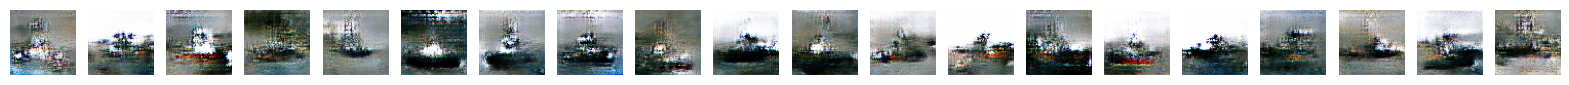

Modelo salvo após 100 épocas.
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 307ms/step - d_loss: 0.3375 - g_loss: 2.7457
Epoch 101/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.3068 - g_loss: 2.9286   - FID: 98.31549072265625 .
Melhor FID encontardo: 98.31549072265625, salvando gerador...
169/169 ━━━━━━━━━━━━━━━━━━━━ 55s 323ms/step - d_loss: 0.3069 - g_loss: 2.9276
Epoch 102/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.3314 - g_loss: 2.2437   - FID: 95.30498504638672 .
Melhor FID encontardo: 95.30498504638672, salvando gerador...
169/169 ━━━━━━━━━━━━━━━━━━━━ 51s 303ms/step - d_loss: 0.3313 - g_loss: 2.2442
Epoch 103/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.3527 - g_loss: 2.3667   - FID: 99.928466796875 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 306ms/step - d_loss: 0.3528 - g_loss: 2.3665
Epoch 104/2000
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.3717 - g_loss: 2.5279   - FID: 125.399658203125 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 305ms/step - d_loss: 0.3

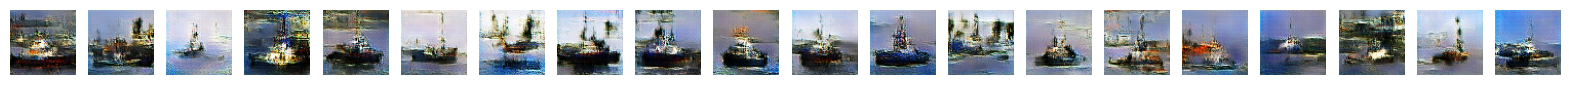

Modelo salvo após 200 épocas.
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 307ms/step - d_loss: 0.3675 - g_loss: 2.3024
Epoch 201/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.3690 - g_loss: 2.4437   - FID: 91.89137268066406 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 51s 304ms/step - d_loss: 0.3689 - g_loss: 2.4438
Epoch 202/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.4048 - g_loss: 2.2474   - FID: 87.70279693603516 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 304ms/step - d_loss: 0.4047 - g_loss: 2.2474
Epoch 203/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.3509 - g_loss: 2.5102   - FID: 88.20255279541016 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 305ms/step - d_loss: 0.3510 - g_loss: 2.5094
Epoch 204/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.3333 - g_loss: 2.5885   - FID: 79.88975524902344 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 51s 303ms/step - d_loss: 0.3334 - g_loss: 2.5888
Epoch 205/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.3524 - g_loss: 2.6941   - FID: 

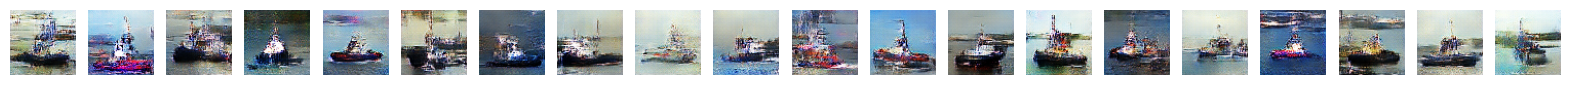

Modelo salvo após 300 épocas.
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 307ms/step - d_loss: 0.3854 - g_loss: 2.1990
Epoch 301/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.4004 - g_loss: 2.2996   - FID: 54.45278549194336 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 83s 311ms/step - d_loss: 0.4004 - g_loss: 2.2994
Epoch 302/2000
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.3886 - g_loss: 2.4518   - FID: 60.76347351074219 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 311ms/step - d_loss: 0.3885 - g_loss: 2.4529
Epoch 303/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.3171 - g_loss: 2.6316   - FID: 69.18384552001953 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 305ms/step - d_loss: 0.3171 - g_loss: 2.6311
Epoch 304/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.3368 - g_loss: 2.7509   - FID: 56.91813659667969 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 51s 303ms/step - d_loss: 0.3368 - g_loss: 2.7499
Epoch 305/2000
167/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.3704 - g_loss: 2.3138   - FID: 

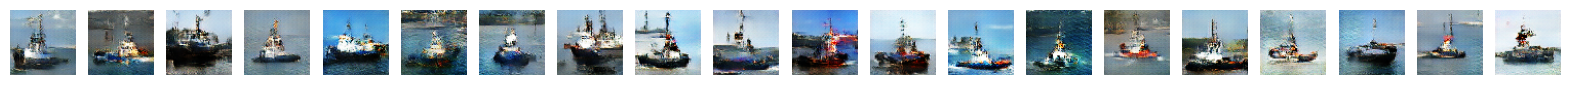

Modelo salvo após 400 épocas.
169/169 ━━━━━━━━━━━━━━━━━━━━ 53s 312ms/step - d_loss: 0.3395 - g_loss: 2.3809
Epoch 401/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.3214 - g_loss: 2.5622   - FID: 53.253231048583984 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 51s 304ms/step - d_loss: 0.3215 - g_loss: 2.5622
Epoch 402/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.3351 - g_loss: 2.6446   - FID: 53.949459075927734 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 307ms/step - d_loss: 0.3351 - g_loss: 2.6443
Epoch 403/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.3046 - g_loss: 2.5647   - FID: 55.00634002685547 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 307ms/step - d_loss: 0.3046 - g_loss: 2.5653
Epoch 404/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.3341 - g_loss: 2.5730   - FID: 48.935184478759766 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 51s 305ms/step - d_loss: 0.3341 - g_loss: 2.5732
Epoch 405/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.3561 - g_loss: 2.5015   - FI

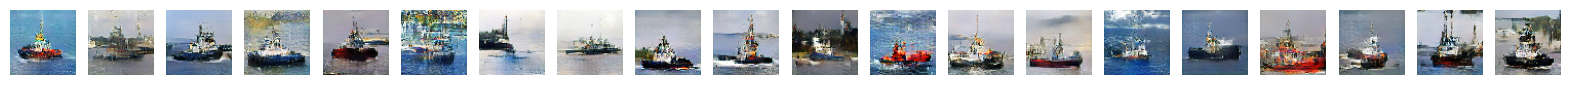

Modelo salvo após 500 épocas.
169/169 ━━━━━━━━━━━━━━━━━━━━ 53s 314ms/step - d_loss: 0.3015 - g_loss: 2.6047
Epoch 501/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.3495 - g_loss: 2.4641   - FID: 45.723060607910156 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 305ms/step - d_loss: 0.3493 - g_loss: 2.4647
Epoch 502/2000
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.3193 - g_loss: 2.4742   - FID: 45.32542037963867 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 307ms/step - d_loss: 0.3193 - g_loss: 2.4742
Epoch 503/2000
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.3198 - g_loss: 2.4947   - FID: 42.50170135498047 .
Melhor FID encontardo: 42.50170135498047, salvando gerador...
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 310ms/step - d_loss: 0.3197 - g_loss: 2.4950
Epoch 504/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.3340 - g_loss: 2.4786   - FID: 48.73953628540039 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 308ms/step - d_loss: 0.3340 - g_loss: 2.4789
Epoch 505/2000
168/169 ━━━━━━━━━━━━━━

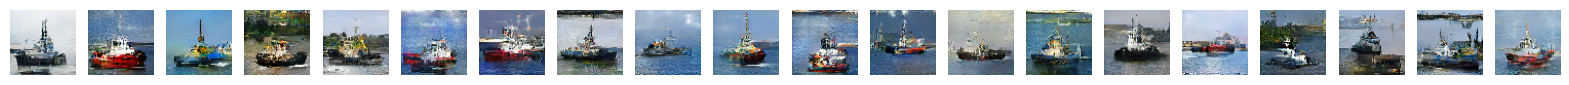

Modelo salvo após 600 épocas.
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 309ms/step - d_loss: 0.2825 - g_loss: 2.8629
Epoch 601/2000
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.2985 - g_loss: 2.6029   - FID: 49.457035064697266 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 51s 304ms/step - d_loss: 0.2984 - g_loss: 2.6030
Epoch 602/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.2938 - g_loss: 2.5879   - FID: 52.58955001831055 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 306ms/step - d_loss: 0.2938 - g_loss: 2.5883
Epoch 603/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.2523 - g_loss: 3.0131   - FID: 45.975257873535156 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 53s 311ms/step - d_loss: 0.2524 - g_loss: 3.0130
Epoch 604/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.2522 - g_loss: 2.9392   - FID: 45.977516174316406 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 305ms/step - d_loss: 0.2523 - g_loss: 2.9395
Epoch 605/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.2628 - g_loss: 2.8860   - FI

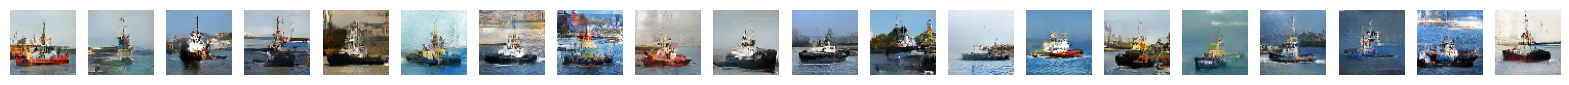

Modelo salvo após 700 épocas.
169/169 ━━━━━━━━━━━━━━━━━━━━ 53s 312ms/step - d_loss: 0.2366 - g_loss: 3.1548
Epoch 701/2000
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.2214 - g_loss: 3.2789   - FID: 44.32160949707031 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 306ms/step - d_loss: 0.2215 - g_loss: 3.2792
Epoch 702/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.2253 - g_loss: 3.2550   - FID: 42.0505485534668 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 310ms/step - d_loss: 0.2253 - g_loss: 3.2558
Epoch 703/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.2046 - g_loss: 3.5553   - FID: 44.07903289794922 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 308ms/step - d_loss: 0.2047 - g_loss: 3.5546
Epoch 704/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.2105 - g_loss: 3.4415   - FID: 47.410064697265625 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 309ms/step - d_loss: 0.2106 - g_loss: 3.4413
Epoch 705/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.2437 - g_loss: 3.3014   - FID: 

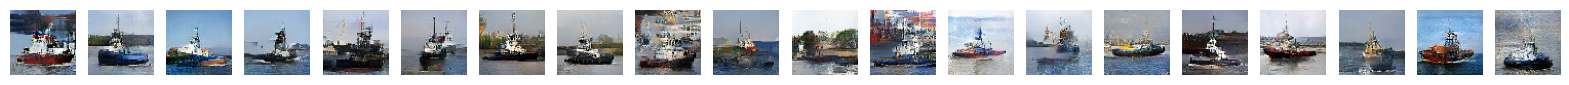

Modelo salvo após 800 épocas.
169/169 ━━━━━━━━━━━━━━━━━━━━ 54s 319ms/step - d_loss: 0.1837 - g_loss: 4.1435
Epoch 801/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.1681 - g_loss: 4.1866   - FID: 44.02979278564453 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 53s 313ms/step - d_loss: 0.1681 - g_loss: 4.1868
Epoch 802/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.1564 - g_loss: 4.3135   - FID: 41.73659896850586 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 54s 322ms/step - d_loss: 0.1564 - g_loss: 4.3131
Epoch 803/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.1458 - g_loss: 4.4878   - FID: 48.174869537353516 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 55s 329ms/step - d_loss: 0.1458 - g_loss: 4.4872
Epoch 804/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.1393 - g_loss: 4.5432   - FID: 42.754737854003906 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 307ms/step - d_loss: 0.1394 - g_loss: 4.5432
Epoch 805/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.1577 - g_loss: 4.3420   - FID

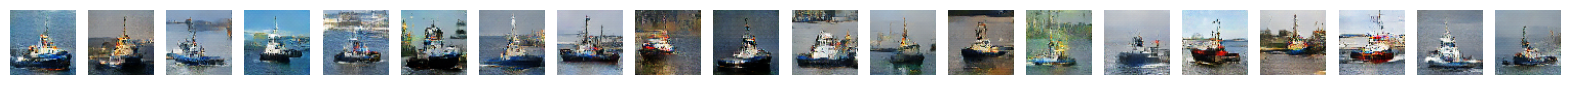

Modelo salvo após 900 épocas.
169/169 ━━━━━━━━━━━━━━━━━━━━ 54s 322ms/step - d_loss: 0.1032 - g_loss: 5.4348
Epoch 901/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.1074 - g_loss: 5.5316   - FID: 46.404998779296875 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 53s 313ms/step - d_loss: 0.1074 - g_loss: 5.5314
Epoch 902/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.1099 - g_loss: 5.6359   - FID: 41.40550994873047 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 53s 315ms/step - d_loss: 0.1099 - g_loss: 5.6353
Epoch 903/2000
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.1071 - g_loss: 5.4307   - FID: 40.279415130615234 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 310ms/step - d_loss: 0.1072 - g_loss: 5.4309
Epoch 904/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.0977 - g_loss: 5.7472   - FID: 44.164520263671875 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 308ms/step - d_loss: 0.0978 - g_loss: 5.7458
Epoch 905/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.1016 - g_loss: 5.5001   - FI

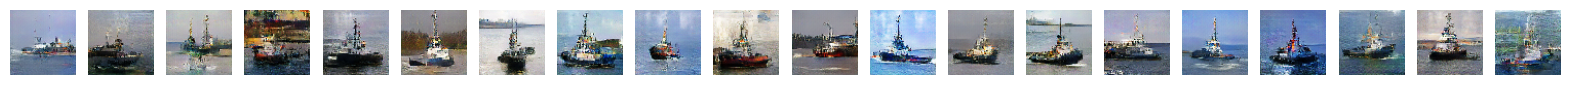

Modelo salvo após 1000 épocas.
169/169 ━━━━━━━━━━━━━━━━━━━━ 54s 317ms/step - d_loss: 0.0749 - g_loss: 6.7455
Epoch 1001/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.0717 - g_loss: 6.9331   - FID: 42.16093826293945 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 53s 312ms/step - d_loss: 0.0717 - g_loss: 6.9338
Epoch 1002/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.0621 - g_loss: 7.0698   - FID: 40.43805694580078 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 309ms/step - d_loss: 0.0622 - g_loss: 7.0697
Epoch 1003/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.0766 - g_loss: 7.0510   - FID: 40.972721099853516 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 306ms/step - d_loss: 0.0766 - g_loss: 7.0502
Epoch 1004/2000
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.0705 - g_loss: 7.0672   - FID: 40.79056167602539 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 305ms/step - d_loss: 0.0706 - g_loss: 7.0666
Epoch 1005/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.0684 - g_loss: 7.1070   

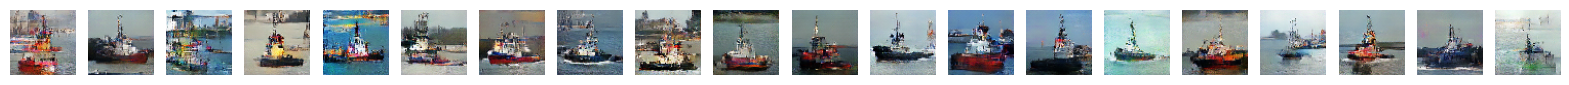

Modelo salvo após 1100 épocas.
169/169 ━━━━━━━━━━━━━━━━━━━━ 53s 313ms/step - d_loss: 0.0390 - g_loss: 8.6668
Epoch 1101/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.0430 - g_loss: 8.6010   - FID: 41.09683609008789 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 311ms/step - d_loss: 0.0430 - g_loss: 8.6002
Epoch 1102/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.0528 - g_loss: 8.4798   - FID: 43.57201385498047 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 309ms/step - d_loss: 0.0528 - g_loss: 8.4789
Epoch 1103/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.0541 - g_loss: 8.5258   - FID: 40.877838134765625 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 307ms/step - d_loss: 0.0540 - g_loss: 8.5258
Epoch 1104/2000
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - d_loss: 0.0578 - g_loss: 8.5321   - FID: 41.52976608276367 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 53s 311ms/step - d_loss: 0.0577 - g_loss: 8.5325
Epoch 1105/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.0434 - g_loss: 8.5596   

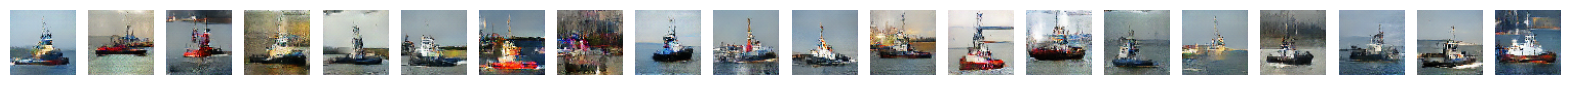

Modelo salvo após 1200 épocas.
169/169 ━━━━━━━━━━━━━━━━━━━━ 54s 322ms/step - d_loss: 0.0130 - g_loss: 10.5825
Epoch 1201/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.0261 - g_loss: 10.1020   - FID: 43.594627380371094 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 53s 316ms/step - d_loss: 0.0261 - g_loss: 10.1039
Epoch 1202/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.0300 - g_loss: 10.7515   - FID: 41.85187911987305 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 53s 315ms/step - d_loss: 0.0300 - g_loss: 10.7509
Epoch 1203/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.0157 - g_loss: 10.8586   - FID: 42.500877380371094 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 309ms/step - d_loss: 0.0158 - g_loss: 10.8579
Epoch 1204/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.0358 - g_loss: 10.4469   - FID: 43.86717224121094 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 53s 314ms/step - d_loss: 0.0358 - g_loss: 10.4467
Epoch 1205/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.0226 - g_loss:

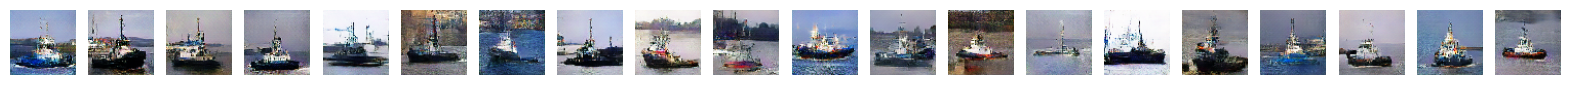

Modelo salvo após 1300 épocas.
169/169 ━━━━━━━━━━━━━━━━━━━━ 53s 315ms/step - d_loss: -0.0020 - g_loss: 13.0546
Epoch 1301/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: -0.0101 - g_loss: 13.2061   - FID: 41.73026657104492 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 310ms/step - d_loss: -0.0100 - g_loss: 13.2065
Epoch 1302/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.0015 - g_loss: 12.6375   - FID: 43.75171661376953 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 53s 315ms/step - d_loss: 0.0015 - g_loss: 12.6369
Epoch 1303/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.0140 - g_loss: 12.4298   - FID: 44.8653564453125 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 311ms/step - d_loss: 0.0140 - g_loss: 12.4317
Epoch 1304/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: -0.0083 - g_loss: 12.7253   - FID: 45.300811767578125 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 310ms/step - d_loss: -0.0083 - g_loss: 12.7264
Epoch 1305/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: 0.0047 - g_lo

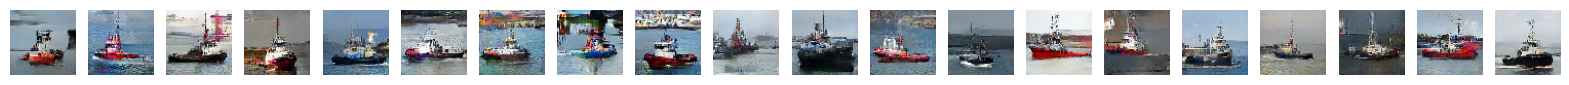

Modelo salvo após 1400 épocas.
169/169 ━━━━━━━━━━━━━━━━━━━━ 55s 324ms/step - d_loss: -0.0374 - g_loss: 16.2718
Epoch 1401/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: -0.0047 - g_loss: 14.1678   - FID: 43.20712661743164 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 53s 314ms/step - d_loss: -0.0047 - g_loss: 14.1683
Epoch 1402/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: -0.0062 - g_loss: 14.0543   - FID: 42.783042907714844 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 53s 314ms/step - d_loss: -0.0062 - g_loss: 14.0556
Epoch 1403/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: -0.0201 - g_loss: 14.4532   - FID: 44.57426452636719 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 53s 314ms/step - d_loss: -0.0201 - g_loss: 14.4533
Epoch 1404/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: -0.0325 - g_loss: 15.3890   - FID: 41.26105499267578 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 53s 312ms/step - d_loss: -0.0325 - g_loss: 15.3907
Epoch 1405/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: -0.0013 

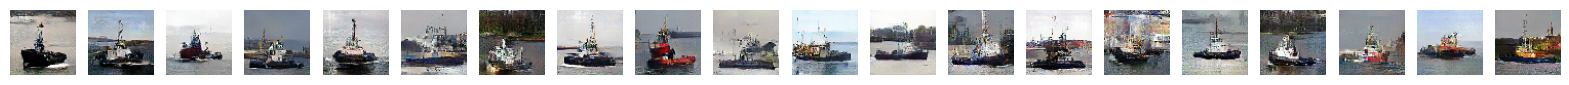

Modelo salvo após 1500 épocas.
169/169 ━━━━━━━━━━━━━━━━━━━━ 56s 329ms/step - d_loss: -0.0212 - g_loss: 17.1349
Epoch 1501/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: -0.0378 - g_loss: 17.9400   - FID: 43.246063232421875 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 55s 324ms/step - d_loss: -0.0378 - g_loss: 17.9406
Epoch 1502/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: -0.0287 - g_loss: 19.2037   - FID: 44.94864273071289 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 54s 319ms/step - d_loss: -0.0288 - g_loss: 19.2040
Epoch 1503/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: -0.0185 - g_loss: 17.4523   - FID: 42.651634216308594 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 54s 317ms/step - d_loss: -0.0186 - g_loss: 17.4543
Epoch 1504/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: -0.0223 - g_loss: 17.4492   - FID: 45.01287841796875 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 53s 314ms/step - d_loss: -0.0223 - g_loss: 17.4495
Epoch 1505/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: -0.0533

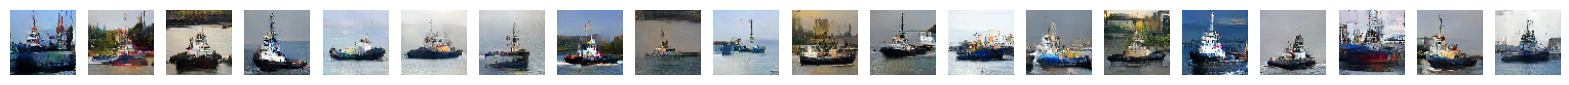

Modelo salvo após 1600 épocas.
169/169 ━━━━━━━━━━━━━━━━━━━━ 55s 324ms/step - d_loss: -0.0648 - g_loss: 20.5669
Epoch 1601/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: -0.0443 - g_loss: 20.1927   - FID: 42.365386962890625 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 55s 327ms/step - d_loss: -0.0444 - g_loss: 20.1988
Epoch 1602/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: -0.0628 - g_loss: 22.4219   - FID: 43.34567642211914 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 55s 325ms/step - d_loss: -0.0627 - g_loss: 22.4179
Epoch 1603/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: -0.0180 - g_loss: 20.3851   - FID: 45.04182434082031 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 54s 321ms/step - d_loss: -0.0181 - g_loss: 20.3850
Epoch 1604/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: -0.0223 - g_loss: 20.1737   - FID: 42.48509979248047 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 54s 319ms/step - d_loss: -0.0224 - g_loss: 20.1751
Epoch 1605/2000
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: -0.0660 

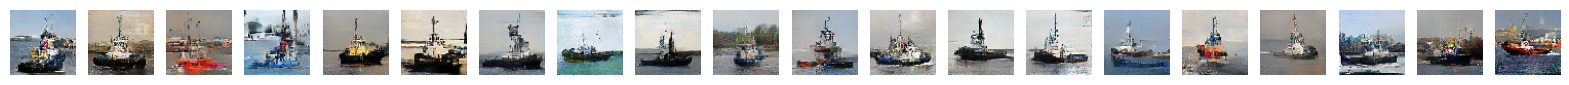

Modelo salvo após 1700 épocas.
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 310ms/step - d_loss: -0.0814 - g_loss: 24.0647
Epoch 1701/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: -0.0785 - g_loss: 24.0821   - FID: 43.4117317199707 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 53s 311ms/step - d_loss: -0.0785 - g_loss: 24.0831
Epoch 1702/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: -0.1148 - g_loss: 26.8089   - FID: 42.65465545654297 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 53s 311ms/step - d_loss: -0.1148 - g_loss: 26.8069
Epoch 1703/2000
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: -0.0824 - g_loss: 24.1905   - FID: 43.9871940612793 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 55s 323ms/step - d_loss: -0.0823 - g_loss: 24.1912
Epoch 1704/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: -0.0733 - g_loss: 23.5938   - FID: 41.95585632324219 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 55s 322ms/step - d_loss: -0.0733 - g_loss: 23.5952
Epoch 1705/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: -0.0932 - g

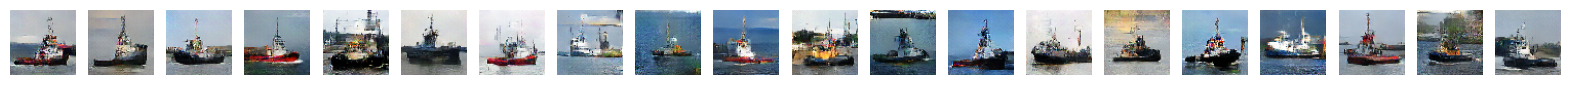

Modelo salvo após 1800 épocas.
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 309ms/step - d_loss: -0.0937 - g_loss: 28.0438
Epoch 1801/2000
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: -0.1016 - g_loss: 27.9702   - FID: 43.365013122558594 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 310ms/step - d_loss: -0.1016 - g_loss: 27.9713
Epoch 1802/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: -0.1194 - g_loss: 28.3966   - FID: 41.67786407470703 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 309ms/step - d_loss: -0.1194 - g_loss: 28.3974
Epoch 1803/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: -0.1226 - g_loss: 28.9134   - FID: 40.23952102661133 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 53s 314ms/step - d_loss: -0.1226 - g_loss: 28.9134
Epoch 1804/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: -0.1191 - g_loss: 28.2888   - FID: 42.94636535644531 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 309ms/step - d_loss: -0.1191 - g_loss: 28.2909
Epoch 1805/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: -0.1051 

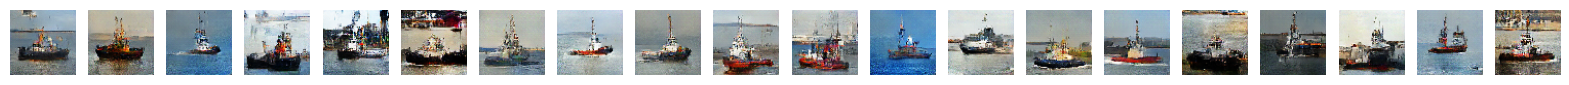

Modelo salvo após 1900 épocas.
169/169 ━━━━━━━━━━━━━━━━━━━━ 54s 318ms/step - d_loss: -0.1368 - g_loss: 33.8592
Epoch 1901/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: -0.1214 - g_loss: 33.7854   - FID: 46.573211669921875 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 53s 315ms/step - d_loss: -0.1215 - g_loss: 33.7828
Epoch 1902/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: -0.1058 - g_loss: 32.2086   - FID: 43.96575927734375 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 53s 313ms/step - d_loss: -0.1059 - g_loss: 32.2162
Epoch 1903/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: -0.1445 - g_loss: 33.0691   - FID: 43.150299072265625 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 52s 311ms/step - d_loss: -0.1445 - g_loss: 33.0728
Epoch 1904/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: -0.1292 - g_loss: 33.7012   - FID: 42.76040267944336 .
169/169 ━━━━━━━━━━━━━━━━━━━━ 53s 314ms/step - d_loss: -0.1292 - g_loss: 33.7017
Epoch 1905/2000
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - d_loss: -0.0982

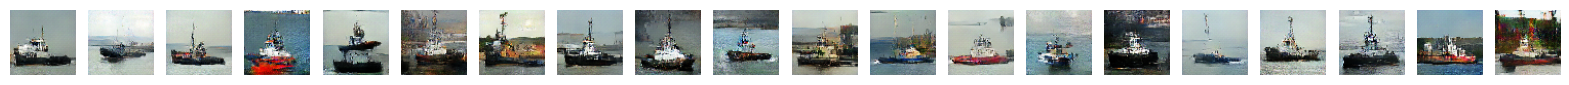

Modelo salvo após 2000 épocas.
169/169 ━━━━━━━━━━━━━━━━━━━━ 54s 320ms/step - d_loss: -0.1446 - g_loss: 37.3725


In [10]:
### EXECUÇÃO ###



epochs = 2000
d_steps = 3
latent_dim = 128

save_fid = np.zeros(epochs)

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim, d_steps=d_steps)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

history = gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=540, latent_dim=latent_dim)]
)

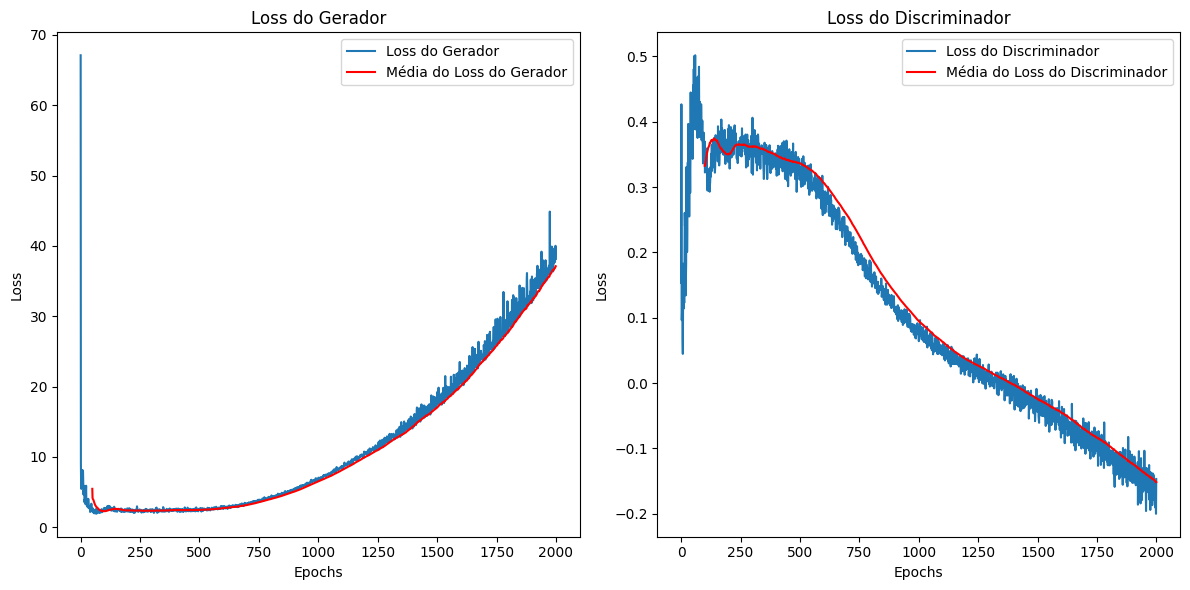

In [11]:
generator_loss = history.history['g_loss']
generator_loss_series = pd.Series(generator_loss)
generator_loss_rolling = generator_loss_series.rolling(window=50).mean()

discriminator_loss = history.history['d_loss']
discriminator_loss_series = pd.Series(discriminator_loss)
discriminator_loss_rolling = discriminator_loss_series.rolling(window=100).mean()

plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.plot(generator_loss, label='Loss do Gerador')
plt.plot(generator_loss_rolling, color='r', linestyle='-', label = 'Média do Loss do Gerador')
plt.title('Loss do Gerador')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(discriminator_loss, label='Loss do Discriminador')
plt.plot(discriminator_loss_rolling, color='r', linestyle='-', label = 'Média do Loss do Discriminador')
plt.title('Loss do Discriminador')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Menor FID:           37.75035858154297
Época da menor perda:  1389


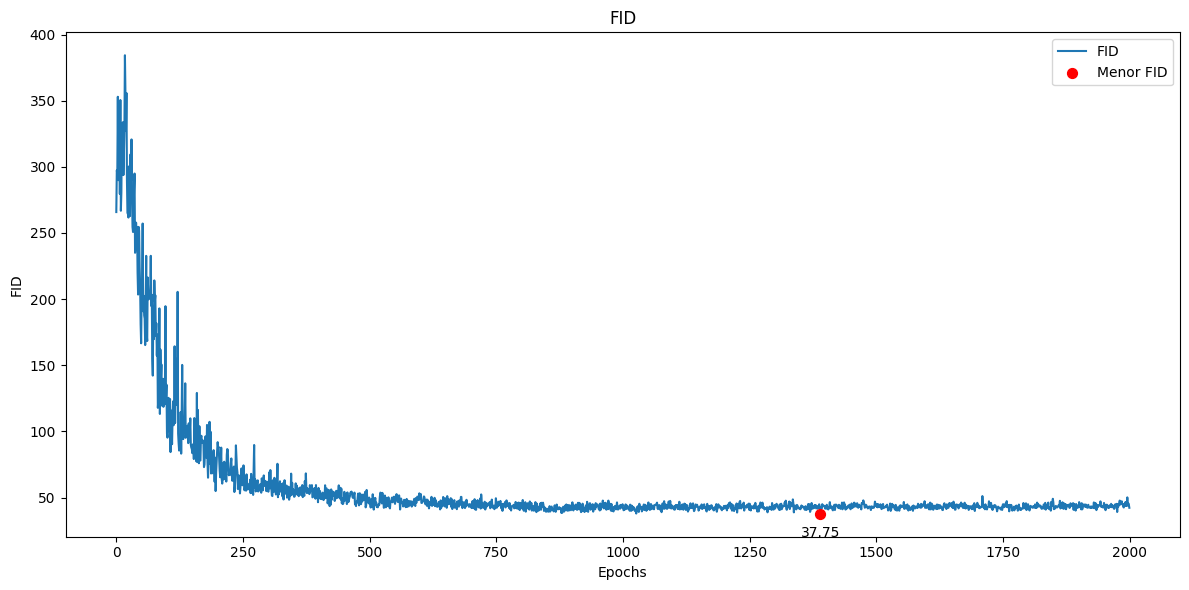

In [12]:
menor_fid = 999
for i in range(epochs):
    if save_fid[i]<menor_fid:
        menor_fid = save_fid[i]
        epoch_m = i
        
print('Menor FID:          ',menor_fid)
print('Época da menor perda: ',epoch_m)

plt.figure(figsize=(12,6))
plt.plot(save_fid, label='FID')
plt.scatter(epoch_m, menor_fid, color='r', zorder=5, label = 'Menor FID', s=50)
plt.text(epoch_m, menor_fid-20, f"{menor_fid:.2f}", ha='center', va='bottom')
plt.title('FID')
plt.xlabel('Epochs')
plt.ylabel('FID')
plt.legend()

plt.tight_layout()
plt.show()

In [13]:
generator = keras.models.load_model(best_path)
discriminator = keras.models.load_model(best_path.replace("best_dcgan_checkpoint", "best_dcgan_discriminator"))

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim, d_steps=d_steps)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

In [14]:
num_img = 5400
output_dir = str(fake_dir + "/" + generating_class + "/")
os.makedirs(output_dir, exist_ok=True)
filename = str(generating_class + "%d.png")
output_path = os.path.join(output_dir, filename)

latent_dim=128
seed_generator = keras.random.SeedGenerator(1337)

for i in tqdm(range(num_img),desc="Gerando imagens"):
    random_latent_vectors = keras.random.normal(
        shape=(1, latent_dim), seed=seed_generator
    )
    generated_images = gan.generator(random_latent_vectors)
    generated_images *= 255
    generated_images.numpy()
    img = keras.utils.array_to_img(generated_images[0])
    img.save(output_path % (i))

Gerando imagens: 100%|██████████████████████████████████████████████████████████████| 5400/5400 [00:56<00:00, 96.25it/s]


/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028
Processando classe 'TUG': 100%|███████████████████████████████████████████████████████| 540/540 [07:53<00:00,  1.14it/s]



Métricas para a classe 'TUG':
  SSIM (média): 0.1650
  Inception Score (Real): 1.9153
  Inception Score (Gerado): 1.7119
  FID: 27.5381


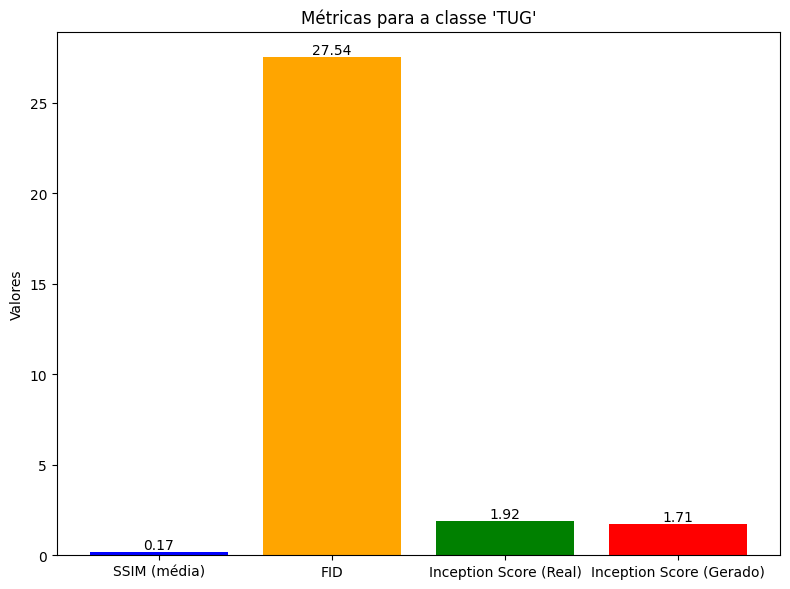

In [15]:
metrics = calculate_metrics(real_dir, fake_dir, generating_class, num_samples=num_img)
print_metrics(metrics, generating_class)
plot_metrics_for_class(metrics, generating_class)

In [16]:
# Caminhos para as imagens de entrada e saída
input_dir = str(fake_dir + '/' + generating_class)   # Substitua pelo diretório das imagens de entrada
output_dir = str(fake_dirx4 + '/' + generating_class)  # Substitua pelo diretório das imagens de saída

# Certifique-se de que o diretório de saída existe
os.makedirs(output_dir, exist_ok=True)

process_images(input_dir, output_dir)
print("Processamento concluído!")

Aumentando imagens: 100%|███████████████████████████████████████████████████████████| 5400/5400 [04:39<00:00, 19.31it/s]

Processamento concluído!


Processando classe 'TUG': 100%|███████████████████████████████████████████████████████| 540/540 [08:21<00:00,  1.08it/s]



Métricas para a classe 'TUG':
  SSIM (média): 0.2070
  Inception Score (Real): 1.9156
  Inception Score (Gerado): 1.7941
  FID: 14.5749


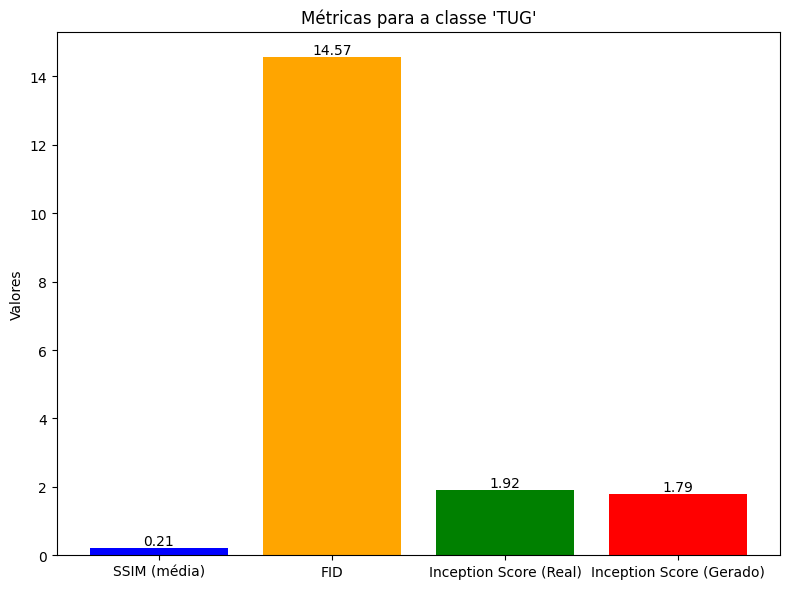

In [17]:
metrics = calculate_metrics(real_dir, fake_dirx4, generating_class, num_samples=num_img)
print_metrics(metrics, generating_class)
plot_metrics_for_class(metrics, generating_class)